# Image classification using LoRA with Vision Transformers

## Introduction

In this notebook, we will learn how to use [LoRA](https://arxiv.org/abs/2106.09685) from 🤗 PEFT to fine-tune an image classification model by ONLY using **0.72%** of the original trainable parameters of the model.

LoRA adds low-rank "update matrices" to certain blocks in the underlying model (in this case the attention blocks) and ONLY trains those matrices during fine-tuning. During inference, these update matrices are _merged_ with the original model parameters. For more details, check out the [original LoRA paper](https://arxiv.org/abs/2106.09685).


__*Note that this notebook builds on top the [image classification with LoRA notebook](https://huggingface.co/docs/peft/task_guides/image_classification_lora).*__

##What is LoRA

![LoRA illisturation](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/peft/lora_diagram.png)

LoRA (Low-rank Optimization for Rapid Adaptation) is a parameter-efficient training method that utilizes low-rank decomposition to reduce the number of trainable parameters. Instead of updating the entire weight matrix, LoRA employs smaller matrices that adapt to new data while maintaining the original weight matrix.

To implement LoRA, we first freeze the pre-trained model weights and then insert trainable rank decomposition matrices into each layer of the transformer architecture. These matrices are much smaller than the original model weights and can capture the essential information for the adaptation. By multiplying the rank decomposition matrices with the frozen weights, we obtain a low-rank approximation of the adapted model weights. This way, we can reduce the number of trainable parameters by several orders of magnitude and also save GPU memory and inference time.

For example, let's suppose we have a pre-trained model with 100 million parameters and 50 layers, and we want to fine-tune the model. If we use LoRA, we can insert two rank decomposition matrices of size 100 x 10 and 10 x 100 into each layer of the model. By multiplying these matrices with the frozen weights, we can obtain a low-rank approximation of the adapted weights with only 2000 parameters per layer. This means that we can reduce the number of trainable parameters from 100 million to 2 million, which is a 50 times reduction. Moreover, we can also speed up the inference process by using the low-rank approximation instead of the original weights.

This approach offers several benefits:

1.   Reduced Trainable Parameters: LoRA significantly reduces the number of trainable parameters, leading to faster training and reduced memory consumption.
2.   Frozen Pre-trained Weights: The original weight matrix remains frozen, allowing it to be used as a foundation for multiple lightweight LoRA models. This facilitates efficient transfer learning and domain adaptation.
3.  Compatibility with Other Parameter-Efficient Methods: LoRA can be seamlessly integrated with other parameter-efficient techniques, such as knowledge distillation and pruning, further enhancing model efficiency.
4.  Comparable Performance: LoRA achieves performance comparable to fully fine-tuned models, demonstrating its effectiveness in preserving model accuracy despite reducing trainable parameters.



Let's get started by installing the dependencies.

## Imports
---

In [1]:
%%capture
!pip install datasets
!pip install evaluate
!pip install accelerate -U
!pip install peft

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
from datasets import load_dataset
from transformers import AutoImageProcessor, ViTForImageClassification
from transformers import Trainer, TrainingArguments
import evaluate

## Authentication

We will share our fine-tuned model at the end of training. So, to do that we just authenticate using our 🤗 token. This token is available from [here](https://huggingface.co/settings/tokens). If you don't have a 🤗 account already, we highly encourage you to do so; it's free!

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Loading the Dataset
---

- We'll be using [Oxford-IIIT Pets Dataset](https://huggingface.co/datasets/pcuenq/oxford-pets)
- It is a collection of 37 different cat and dog breed images.

In [4]:
dataset = load_dataset('pcuenq/oxford-pets')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7390 [00:00<?, ? examples/s]

The dataset contains the following features:

- path: a path to the file
- label: the breed of the animal
- dog: indicates if the animal is a dog or not
- image: a PIL Image

In [5]:
dataset['train'][0]

{'path': '/data/datasets/magic-ml/oxford-iiit-pet/images/Siamese_137.jpg',
 'label': 'Siamese',
 'dog': False,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=345x500>}

Let's check the classes

In [6]:
classes = dataset['train'].unique('label')
print(len(classes),classes)

37 ['Siamese', 'Birman', 'shiba inu', 'staffordshire bull terrier', 'basset hound', 'Bombay', 'japanese chin', 'chihuahua', 'german shorthaired', 'pomeranian', 'beagle', 'english cocker spaniel', 'american pit bull terrier', 'Ragdoll', 'Persian', 'Egyptian Mau', 'miniature pinscher', 'Sphynx', 'Maine Coon', 'keeshond', 'yorkshire terrier', 'havanese', 'leonberger', 'wheaten terrier', 'american bulldog', 'english setter', 'boxer', 'newfoundland', 'Bengal', 'samoyed', 'British Shorthair', 'great pyrenees', 'Abyssinian', 'pug', 'saint bernard', 'Russian Blue', 'scottish terrier']


#### Let's see some sample images from the dataset.

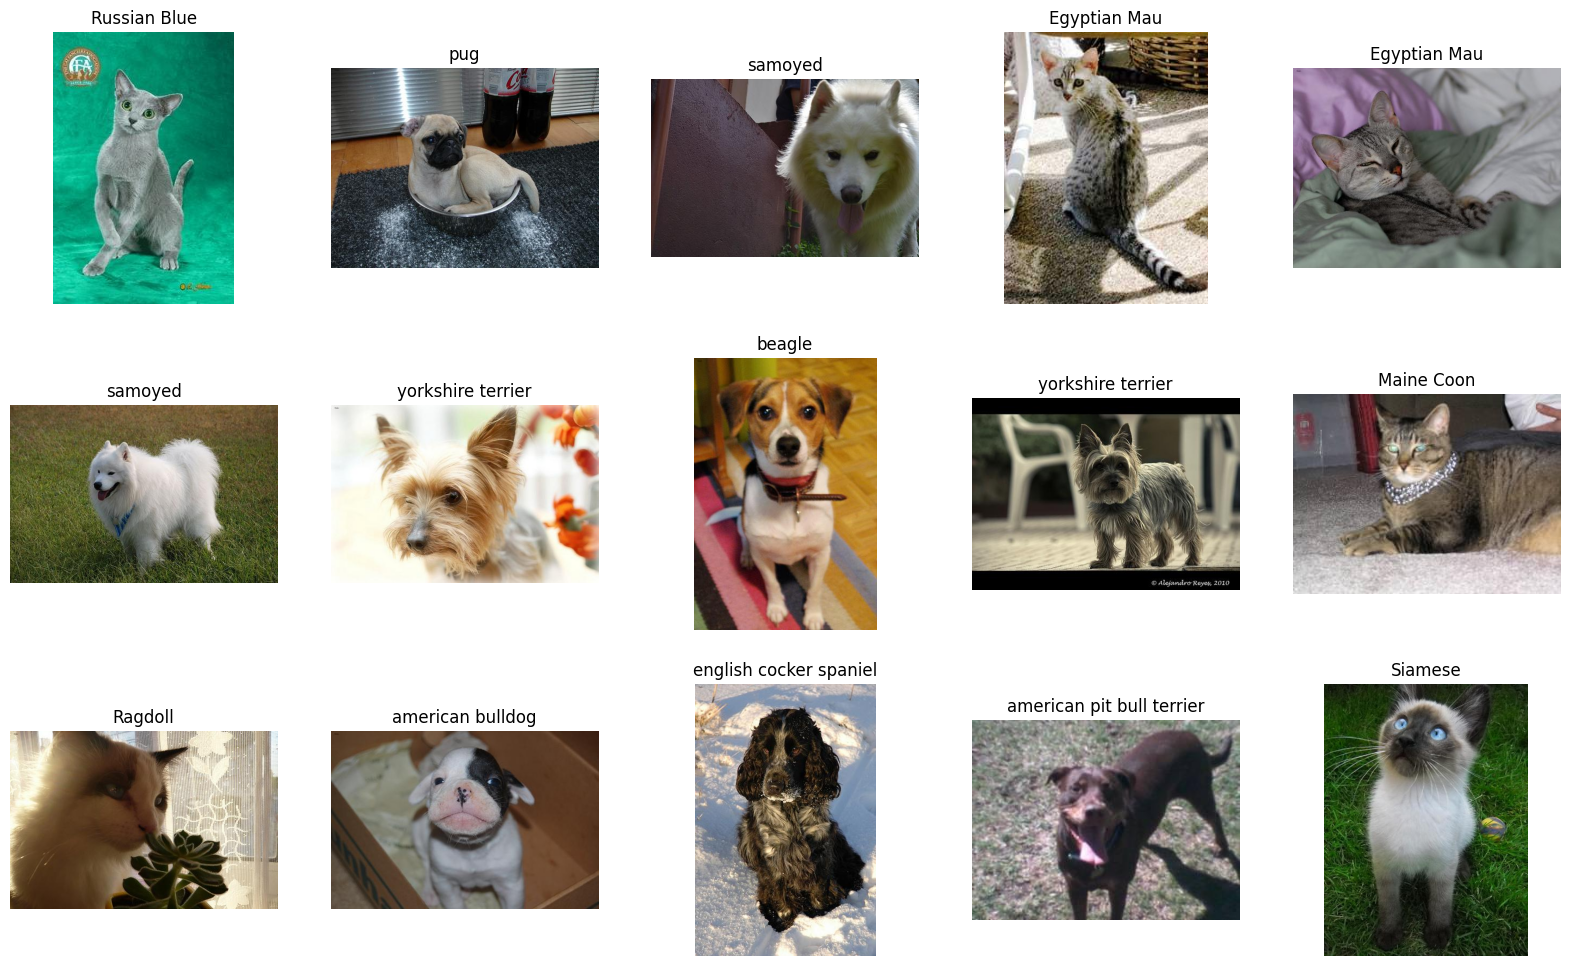

In [7]:
def show_samples(ds,rows=2,cols=4):
    samples = ds.shuffle().select(np.arange(rows*cols))
    fig = plt.figure(figsize=(cols*4,rows*4))
    for i in range(rows*cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_samples(dataset['train'],rows=3,cols=5)

## Preprocessing
---

In this section we ensure the dataset is properly formatted, transformed, and ready to be fed into the ViT model for training. It handles data loading, exploration, splitting, and transformation steps necessary to facilitate efficient training and evaluation of the image classification model using the LoRA methodology.

Let's start with first split the dataset into `train` for training and `test` for evaluation.

In [8]:
dataset = dataset['train'].train_test_split(train_size=0.8)
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 5912
    })
    test: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 1478
    })
})

To prepare the inputs for the model, we have to apply the required transformations. This can be achieved by utilizing the `AutoImageProcessor` module, which loads the appropriate transformations corresponding to the relevant model. We can see which transformations are used in the processor config.

In [9]:
model_name = "vit-base-patch16-224"
model_checkpoint = f"google/{model_name}"

processor = AutoImageProcessor.from_pretrained(model_checkpoint)
processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

We'll also map the label names to indices with `label2id` and `id2label` so it is easy for us to read.

In [10]:
label2id = {c:idx for idx,c in enumerate(classes)}
id2label = {idx:c for idx,c in enumerate(classes)}

We can create a function which will preprocess the batch. The trainer will call this function when we add it to the dataset using `with_transform` during training time.

In this `transforms` function, we do the following:

- It might be possible that some images in your dataset will be grayscale or transparent (RGBA).To avoid dimension errors, it is safer to convert them to RGB using PIL convert method.
- We pass the images through the processor to apply the transforms to process and convert them into PyTorch format.
- Using `label2id` we convert the String labels to their integer representation.

In [11]:
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor([x for x in batch['image']],return_tensors='pt')
    inputs['labels']=[label2id[y] for y in batch['label']]
    return inputs

In [12]:
dataset = dataset.with_transform(transforms)

We also create `collate_fn` function to define how individual samples extracted from a dataset are combined into batches. `collate_fn` is used when iterating through the dataset in the training loop to prepare batches of data that can be fed into the model.

In [13]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

## Metric
---

We can use Hugging Face [evaluate](https://huggingface.co/docs/evaluate/index) library to calculate metrics. For image classification, we can use the accuracy metric

In [14]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    return acc

Before loading the model, let’s define a helper function to check the total number of parameters a model has, as well as how many of them are trainable.

In [15]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

## Model

![Vision Transformer (ViT)](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/vit_architecture.jpg)

The Vision Transformer (ViT) model represents a significant innovation in computer vision tasks, departing from the conventional convolutional neural network (CNN) architecture. It applies the Transformer architecture, originally designed for natural language processing (NLP), directly to image data without relying on CNNs.

ViT processes images by splitting them into sequences of fixed-size non-overlapping patches, linearly embedding these patches, adding absolute position embeddings, and then feeding this sequence of vectors into a standard Transformer encoder. A special token, often referred to as the [CLS] token, is added to serve as the representation of the entire image, allowing for image classification.

To load our pre-trained ViT model, we will use `ViTForImageClassification` class. We will do that by passing in `num_labels` argument along with our label mappings id2label and label2id. We also need to pass `ignore_mismatched_sizes = True` to compensate for the change in number of parameters in the classifier layer.

In [16]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)
print_trainable_parameters(model)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([37, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 85827109 || all params: 85827109 || trainable%: 100.00


Next, we use `get_peft_model` to wrap the base model so that “update” matrices are added to the respective places.

In [17]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)

lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 618277 || all params: 86445386 || trainable%: 0.72


### Let's examine the LoraConfig Parameters:
- `r`: The rank of the update matrices, represented as an integer. Lower rank values result in smaller update matrices with fewer trainable parameters.

- `target_modules`: The modules (such as attention blocks) where the LoRA update matrices should be applied.

- `alpha`: The scaling factor for LoRA.

- `layers_pattern`: A pattern used to match layer names in `target_modules` if `layers_to_transform` is specified. By default, Peft model will use a common layer pattern (layers, h, blocks, etc.). This pattern can also be used for exotic and custom models.

- `rank_pattern`: A mapping from layer names or regular expression expressions to ranks that differ from the default rank specified by `r`.

- `alpha_pattern`: A mapping from layer names or regular expression expressions to alphas that differ from the default alpha specified by `lora_alpha`.

#### Here's our model architecture

In [18]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): lora.Linear(
                (base_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=768, bias=False)
                )
                (lora_embedding_A): ParameterDict()
     


### Let's look at the components of the LoRA model:

- **lora.Linear**: LoRA adapts pre-trained models using a low-rank decomposition. It modifies the linear transformation layers (query, key, value) in the attention mechanism.
  - **base_layer**: The original linear transformation.
  - **lora_dropout**: Dropout applied to the LoRA parameters.
  - **lora_A**: The matrix A in the low-rank decomposition.
  - **lora_B**: The matrix B in the low-rank decomposition.
  - **lora_embedding_A/B**: The learnable embeddings for LoRA.

# Training
---

We'll use HuggingFace Trainer to train our model, we can set our desired training arguments and start the training.

In [19]:
batch_size = 128

args = TrainingArguments(
    f"{model_checkpoint}-finetuned-lora-oxford-pets",
    per_device_train_batch_size=batch_size,
    learning_rate=5e-3,
    num_train_epochs=5,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=4,
    logging_steps=10,
    save_total_limit=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    report_to='tensorboard',
    fp16=True,
    push_to_hub=True,
    remove_unused_columns=False,
    load_best_model_at_end=True,
)

Some things to note here:

* We're using a larger batch size since there is only a handful of parameters to train.
* Larger learning rate than the normal (1e-5 for example).

All of these things are a byproduct of the fact that we're training only a small number of parameters. This can potentially also reduce the need to conduct expensive hyperparameter tuning experiments.

In [20]:
trainer = Trainer(
    model=model,
    args=args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=processor
)

In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.018500,0.165393,0.947226
1,0.008100,0.166164,0.951286
2,0.004200,0.169724,0.950609
4,0.001500,0.168731,0.950609


TrainOutput(global_step=55, training_loss=0.006348868002268401, metrics={'train_runtime': 758.9947, 'train_samples_per_second': 38.946, 'train_steps_per_second': 0.072, 'total_flos': 2.166104653885735e+18, 'train_loss': 0.006348868002268401, 'epoch': 4.68})

## Sharing your model and inference

Once the fine-tuning is done, we can share the LoRA parameters with the community like so:

In [22]:
repo_name = f"alanahmet/{model_name}-finetuned-lora-oxfordPets"
lora_model.push_to_hub(repo_name)

adapter_model.safetensors:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/alanahmet/vit-base-patch16-224-finetuned-lora-oxfordPets/commit/ed7ce5b739c8adbc773f1a39fd7ce95b60837094', commit_message='Upload model', commit_description='', oid='ed7ce5b739c8adbc773f1a39fd7ce95b60837094', pr_url=None, pr_revision=None, pr_num=None)

When we call `push_to_hub()` on the `lora_model`, only the LoRA parameters along with any modules specified in `modules_to_save` are saved. If we take a look at the [trained LoRA parameters](https://huggingface.co/alanahmet/vit-base-patch16-224-finetuned-lora-oxfordPets/blob/main/adapter_model.safetensors), we see that it's only **2.48 MB**! This greatly helps with portability especially when we're using a very large model to fine-tune.

Next, we see how to load the LoRA updated parameters along with our base model for inference. When we wrap a base model with `PeftModel` that modifications are DONE in place. So to mitigate any concerns that might stem from in place modifications, we newly initialize our base model just like we did earlier and construct our inference model.

In [23]:
from peft import PeftConfig, PeftModel


config = PeftConfig.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Load the Lora model
inference_model = PeftModel.from_pretrained(model, repo_name)

adapter_config.json:   0%|          | 0.00/703 [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([37, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

And let's now fetch a sample for inference.

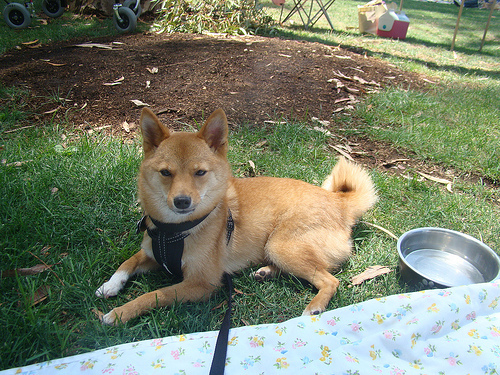

In [24]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/alanahmet/LoRA-pets-dataset/resolve/main/shiba_inu_136.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

We first instantiate an `image_processor` from the underlying model repo.

In [25]:
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

We then prepare the sample for inference.

In [26]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


And run inference!

In [27]:
import torch

# forward pass
with torch.no_grad():
    outputs = inference_model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", inference_model.config.id2label[predicted_class_idx])

Predicted class: shiba inu


# **Conclusion**

In this tutorial, we've explored LoRA (Low-rank Optimization for Rapid Adaptation), a parameter-efficient training methodology that significantly reduces the number of trainable parameters while preserving model accuracy. By utilizing low-rank decomposition, LoRA enables the adaptation of pre-trained models to new data by employing smaller matrices to capture essential information.

Key takeaways from this tutorial include:

1. **Parameter Efficiency**: LoRA reduces the number of trainable parameters, leading to faster training, reduced memory consumption, and improved efficiency in model adaptation.
2. **Adaptation Methodology**: The utilization of rank decomposition matrices inserted into specific layers of the model allows for rapid adaptation to new data while maintaining the original model's foundational knowledge.
3. **Model Performance**: Despite the reduction in trainable parameters, LoRA demonstrates comparable performance to fully fine-tuned models, showcasing its effectiveness in preserving accuracy.

Through step-by-step implementation, we've fine-tuned an image classification model using LoRA. We've covered dataset preparation, model loading, training, and sharing of the LoRA-updated parameters with the wider community.

The ability to efficiently adapt pre-trained models using LoRA provides a powerful approach for practitioners in various domains, allowing for quick adaptation to new data while ensuring resource efficiency and maintaining high model performance.

For further exploration of LoRA in various applications, we encourage further reading of the original LoRA paper and check the available resources provided by Hugging Face.

For more information about LoRA you can check:


*   [Hugging Face Image Classification using LoRA](https://huggingface.co/docs/peft/task_guides/image_classification_lora)
*   [CONCEPTUAL LoRA GUIDE](https://huggingface.co/docs/peft/conceptual_guides/lora)
*   [Computer Vision Course Image Classification with Transer Learning](https://github.com/shreydan/computer-vision-course/blob/main/notebooks/Unit%203%20-%20Vision%20Transformers/transfer-learning.ipynb)
*   [LoRA Paper](https://arxiv.org/abs/2106.09685)